In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from keras.layers import Input
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import clear_output
%matplotlib inline

In [2]:
celebs = ['Irrfan_Khan', 'Jacqueline_Fernandez', 'Juhi_Chawla', 
          'Kajal_Aggarwal', 'Paresh_Rawal']

In [3]:
os.chdir('data/celeb_faces_dataset')
if os.path.isdir('train/Irrfan_Khan/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for c in celebs:
        shutil.move(f'{c}', 'train')
        os.mkdir(f'valid/{c}')
        os.mkdir(f'test/{c}')

        valid_samples = random.sample(os.listdir(f'train/{c}'), 30)
        for i in valid_samples:
            shutil.move(f'train/{c}/{i}', f'valid/{c}')

        test_samples = random.sample(os.listdir(f'train/{c}'), 5)
        for j in test_samples:
            shutil.move(f'train/{c}/{j}', f'test/{c}')
os.chdir('../..')

In [4]:
train_path = 'data/celeb_faces_dataset/train'
valid_path = 'data/celeb_faces_dataset/valid'
test_path = 'data/celeb_faces_dataset/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
               .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=5, shuffle=False)

Found 278 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [6]:
def VGGupdated(input_tensor=None, classes=100):
    
    img_rows, img_cols = 224,224
    img_channels = 3
    
    img_dim = (img_rows, img_cols, img_channels)
    
    img_input = Input(shape=img_dim)
    
    x= Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x= Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv2')(x)
    x= MaxPooling2D((2,2), strides=(2,2), name='block1_pool')(x)
    
    x= Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv1')(x)
    x= Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv2')(x)
    x= MaxPooling2D((2,2), strides=(2,2), name='block2_pool')(x)
    
    x= Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv1')(x)
    x= Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv2')(x)
    x= Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv3')(x)
    x= MaxPooling2D((2,2), strides=(2,2), name='block3_pool')(x)
    
    x= Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv1')(x)
    x= Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv2')(x)
    x= Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv3')(x)
    x= MaxPooling2D((2,2), strides=(2,2), name='block4_pool')(x)
    
    x= Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv1')(x)
    x= Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv2')(x)
    x= Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv3')(x)
    x= MaxPooling2D((2,2), strides=(2,2), name='block5_pool')(x)
    
    
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    
    model = Model(inputs = img_input, outputs = x, name='VGGdemo')
    
    return model

In [11]:
model = VGGupdated(classes = 5)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "VGGdemo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [16]:
callbacks_list = [PlotLearning()]

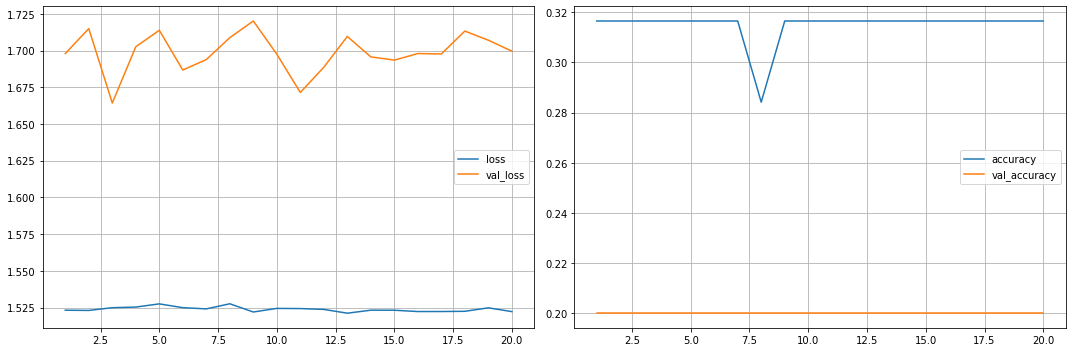

56/56 - 168s - loss: 1.5223 - accuracy: 0.3165 - val_loss: 1.6996 - val_accuracy: 0.2000


In [19]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=20,
            verbose=2,
            callbacks=callbacks_list
)

In [20]:
test_labels = test_batches.classes

In [21]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [22]:
predictions

array([[0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276382],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276382],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.1580986 , 0.31356338, 0.09276383],
       [0.16220172, 0.27337247, 0.

In [23]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_batches.class_indices

{'Irrfan_Khan': 0,
 'Jacqueline_Fernandez': 1,
 'Juhi_Chawla': 2,
 'Kajal_Aggarwal': 3,
 'Paresh_Rawal': 4}

Confusion matrix, without normalization
[[0 0 0 5 0]
 [0 0 0 5 0]
 [0 0 0 5 0]
 [0 0 0 5 0]
 [0 0 0 5 0]]


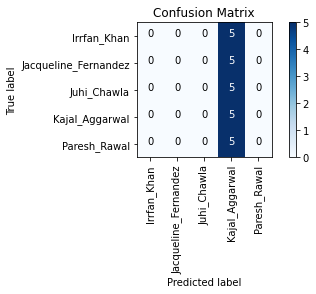

In [26]:
cm_plot_labels = celebs[:]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [27]:
model.save('models\model_20.00_vgg.h5')